In [1]:
import torch
import torchvision
import torch.optim as optim
from data.data import get_train_test_loader
from model.network import FastUpdateNet, FastUpdateNetLarge, Linear_AE
import torch.nn.functional as F

import pickle
import time 

/home/kyle/pythonenvs/venv38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
# torch.manual_seed(random_seed)

In [3]:
train_loader, test_loader = get_train_test_loader('mnist')
device = torch.device('cuda:1')

In [4]:
train_losses = []
train_counter = []
test_losses = []
test_accuracies = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [5]:
from threading import Thread

def train(epoch, network):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)

    optimizer.zero_grad()
    output = network(data)
    _, y = output
    data = data.squeeze(1)
    loss = F.mse_loss(y, data) # compare the reconstructed input to original input
    # print(loss)
    loss.backward()
    # print(network.mNet.saver.grad)
    # p1 = Thread(target=compute_back_M1, args=[network]) # start two independent threads
    # p2 = Thread(target=compute_back_M2, args=[network])
    
    # p1.start()
    # p2.start()
    network.mNet1.backwardHidden()
    network.mNet2.backwardHidden()
    # p1.join() # wait for the two threads to finish
    # return 
    # p2.join()

    # correctness = (target == torch.argmax(output))
    optimizer.step()
    # network.mNet.weightUpdate(correctness, lr = learning_rate)
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [6]:
def test(network):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    ct = 0
    for data, target in test_loader:
      data = data.to(device)
      output = network(data)
      _, y = output
      # print(y.shape)
      # print(data.shape)
      data = data.squeeze(1)
      test_loss = F.mse_loss(y, data) # compare the reconstructed input to original input
      # print(test_loss)
      test_loss += test_loss.item()

      # pred = output.data.max(1, keepdim=True)[1]
      # correct += pred.eq(target.data.view_as(pred)).sum()
      correct = -1
      ct += 1
  test_loss /= ct
  test_losses.append(test_loss)
  # test_accuracies.append(100. * correct / len(test_loader.dataset))
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## Test using 2 Ms (computing grad in main thread and separate thread)

In [7]:

import torch.nn as nn
fNet = Linear_AE().to(device)
# fNet.mNet1 = torch.nn.Sequential(nn.Linear(392, 196), nn.ReLU(), nn.Linear(196, 98), nn.ReLU(), nn.Linear(98, 49), nn.ReLU())
# fNet.mNet2 = torch.nn.Sequential(nn.Linear(392, 196), nn.ReLU(), nn.Linear(196, 98), nn.ReLU(), nn.Linear(98, 49), nn.ReLU())
# optimizer = optim.SGD(fNet.get_parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(fNet.get_parameters(), lr=learning_rate)

/home/kyle/pythonenvs/venv38/lib/python3.10/site-packages/torch/optim/adam.py:137: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


In [8]:
train_losses = []
train_counter = []
test_losses = []
test_accuracies = []

s = time.perf_counter()
n_epochs = 10
test(fNet)
for epoch in range(1, n_epochs + 1):
  train(epoch, fNet)
  test(fNet)
  # if (epoch + 1) % 10 == 0:
  #   torch.save(fNet, 'fNet-stdp-30000-epoch.pt')
  #   with open('fNet-stdp-3000-epoch-loss-accuracy.pkl', 'wb') as f:
  #     pickle.dump({'train_losses':train_losses, 'test_losses': test_losses, 'test_accuracies':test_accuracies}, f, protocol=pickle.HIGHEST_PROTOCOL)

# torch.save(fNet, 'fNet-stdp-30000-epoch.pt')
e = time.perf_counter()
print(f"Training time for {epoch} epochs: {e-s} seconds")


Test set: Avg. loss: 0.2013, Accuracy: -1/10000 (-0%)


Test set: Avg. loss: 0.1437, Accuracy: -1/10000 (-0%)


Test set: Avg. loss: 0.1418, Accuracy: -1/10000 (-0%)


Test set: Avg. loss: 0.1430, Accuracy: -1/10000 (-0%)


Test set: Avg. loss: 0.1431, Accuracy: -1/10000 (-0%)


Test set: Avg. loss: 0.1410, Accuracy: -1/10000 (-0%)


Test set: Avg. loss: 0.1415, Accuracy: -1/10000 (-0%)


Test set: Avg. loss: 0.1409, Accuracy: -1/10000 (-0%)



In [ ]:
import matplotlib.pyplot as plt


def sample_outputs(network, sample_size = 5):
  network = network.to(device)
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data = data.to(device)
          output = network(data)
          _, y = output
          
          data = data.squeeze(1)
          test_loss += F.mse_loss(y, data).item() # compare the reconstructed input to original input

          # plot data vs y
          # print(y.shape)
          # print(data.shape)
          fig, axs = plt.subplots(sample_size, 2)
          for i in range(sample_size):
              print(f'target {i}', target[i])
              y_i = y[i,:,:]
              data_i = data[i,:,:]
              # print(y_i.shape)
              # print(data_i.shape)
              axs[i,0].imshow(data_i.cpu().numpy())
              # plt.show()
            #   print(y_i)
              axs[i,1].imshow(y_i.cpu().numpy())
              # plt.show()
          
          # plt.tight_layout()
          plt.show()



          # pred = output.data.max(1, keepdim=True)[1]
          # correct += pred.eq(target.data.view_as(pred)).sum()
          correct = -1
          break

sample_outputs(fNet)

ValueError: too many values to unpack (expected 2)

target 0 tensor(3)
target 1 tensor(3)


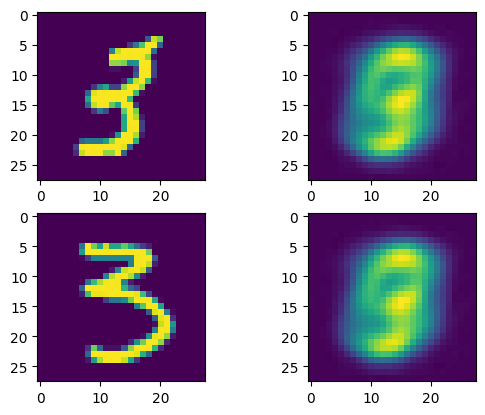

In [ ]:
sample_size = 2
fNet.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = fNet(data)
        _, y = output
        
        data = data.squeeze(1)
        test_loss += F.mse_loss(y, data).item() # compare the reconstructed input to original input

        # plot data vs y
        # print(y.shape)
        # print(data.shape)
        fig, axs = plt.subplots(sample_size, 2)
        for i in range(sample_size):
            print(f'target {i}', target[i])
            y_i = y[i,:,:]
            data_i = data[i,:,:]
            # print(y_i.shape)
            # print(data_i.shape)
            axs[i,0].imshow(data_i.cpu().numpy())
            # plt.show()
            # print(y_i)
            axs[i,1].imshow(y_i.cpu().numpy())
            # plt.show()
        
        # plt.tight_layout()
        plt.show()



        # pred = output.data.max(1, keepdim=True)[1]
        # correct += pred.eq(target.data.view_as(pred)).sum()
        correct = -1
        break

In [ ]:
test_accuracies

[]

## Test using no Ms, and only on main thread

In [ ]:
def train_no_M(epoch, network):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    # print(network.mNet.saver.grad)
    # p1 = Thread(target=compute_back_M1, args=[network]) # start two independent threads
    # # p2 = Thread(target=compute_back_M2, args=[network])
    
    # p1.start()
    # # p2.start()
    # network.mNet2.backwardHidden()
    # p1.join() # wait for the two threads to finish
    # # return 
    # # p2.join()

    correctness = (target == torch.argmax(output))
    optimizer.step()
    # network.mNet.weightUpdate(correctness, lr = learning_rate)
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [ ]:

import torch.nn as nn
fNet = FastUpdateNetLarge()
fNet.mNet1 = torch.nn.Sequential(nn.Linear(392, 196), nn.ReLU(), nn.Linear(196, 98), nn.ReLU(), nn.Linear(98, 49), nn.ReLU())
fNet.mNet2 = torch.nn.Sequential(nn.Linear(392, 196), nn.ReLU(), nn.Linear(196, 98), nn.ReLU(), nn.Linear(98, 49), nn.ReLU())
optimizer = optim.SGD(fNet.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_accuracies = []

s = time.perf_counter()

test(fNet)
for epoch in range(1, n_epochs + 1):
  train_no_M(epoch, fNet)
  test(fNet)
  # if (epoch + 1) % 10 == 0:
  #   torch.save(fNet, 'fNet-stdp-30000-epoch.pt')
  #   with open('fNet-stdp-3000-epoch-loss-accuracy.pkl', 'wb') as f:
  #     pickle.dump({'train_losses':train_losses, 'test_losses': test_losses, 'test_accuracies':test_accuracies}, f, protocol=pickle.HIGHEST_PROTOCOL)

# torch.save(fNet, 'fNet-stdp-30000-epoch.pt')
e = time.perf_counter()
print(f"Training time for {epoch} epochs: {e-s} seconds")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:1! (when checking argument for argument mat1 in method wrapper_addmm)